# Announcements
- Please familiarize yourself with the term projects, and sign up for your (preliminary) choice using [this form](https://forms.gle/ByLLpsthrpjCcxG89). _You may revise your choice, but I'd recommend settling on a choice well before Thanksgiving._
- Recommended reading on ODEs: [Lecture notes by Prof. Hjorth-Jensen (University of Oslo)](https://www.asc.ohio-state.edu/physics/ntg/6810/readings/hjorth-jensen_notes2013_08.pdf)
- Problem Set 4 posted on D2L, due Oct 5.
- __Outlook__: completing ODE examples this week, then Partial Differential Equations (PDEs) 
- Conference for Undergraduate Women in Physics: online event in 2021, [applications accepted until 10/25](https://www.aps.org/programs/women/cuwip/)

# Special Considerations: Symplectic Integrators
Some systems of ODEs have special properties, for example constants of motion, that should be
conserved by the system. Simple examples in mechanics are the energy, linear momentum, and angular
momentum. Sometimes it is more important to build in to the integration scheme these conservation
laws than to achieve a high accuracy per step size. Normally, the error in the solution grows as the
solution evolves, bounded by the number of steps times the error per step.  For certain schemes,
however, while they still make errors, the errors will be of such a form that the conserved quantities
will be better preserved.


In Lecture 15 we derived the __velocity form__ of the Verlet algorithm
\begin{align}
x_{n+1} &= x_n + v_n\delta t + {1\over 2}a_n(\delta t)^2 + \mathcal{O}(\delta t^3) \tag{1a}\\
a_{n+1} &= a(x_{n+1}) \label{eq:Vv}\tag{1b}\\
v_{n+1} &= v_n + {1\over 2}\left(a_n + a_{n+1}\right)\delta t + \mathcal{O}(\delta t^2).\tag{1c}
\end{align}

While the velocity computed in this way is only
first-order accurate, if the acceleration depends only upon position, then the
velocity appears only where multiplied by $\delta t$ in determining the positions and so
second-order accuracy is preserved. Of course, if determining the velocity to
high accuracy is required, then one might turn to a different scheme. On the
other hand, if the acceleration depends upon the velocity (for example, a drag
term), there are fewer constants of the motion to be conserved anyway, and one
of the higher-order schemes developed previously would serve.
<span style="color:red"> Note that Eq.(\ref{eq:Vv}) evaluates $a_{n+1}$ before $v_{n+1}$ can be computed, so the acceleration should only be a function of position, not velocity. _This is by design, as the derivation of the Verlet algorithm was based on conservation of energy._ </span>

Here's one implementation of the velocity Verlet algorithm. Note that we compute the acceleration $a_n$ and $a_{n+1}$ in each call; this is not optimal computationally, but easier to read and use with our existing `odeSolve` code.

In [1]:
import numpy as np
def vVerlet_step(g, t, x,v, h, *P):
    """Implements a full step h of the velocity Verlet algorithm
    Parameters:
        g: function. RHS of ODE, with signature g(t,y[0],*P).
        x: Current position x.
        v: Current velocity v.
        h: float. Step length.
        *P:    tuple, additional parameters for g function
    Returns:
        x,v: numpy arrays: next position, next velocity
    """
    a_current = g(x,*P) 
    
    #advance the position: x_n -> x_n+1
    x += v*h+a_current*h**2
    #compute a_n+1
    a_next = g(x,*P)
    #advance the velocity v_n -> v_n+1
    v +=(a_current+a_next)*h**2
    return x,v

## Example: Planetary Motion 
Today we will study the orbits of two masses interacting through gravity.

In general, the gravitational force on object $j$ with mass $m_j$ and position $\vec{r}_j$ through its gravitational interaction with objects $i$ with mass $m_i$ and position $\vec{x}_i$ is given by
$$
\vec F_j = -\sum_{i\ne j}\frac{G m_j m_i}{|\vec x_i - \vec x_j|^2} \times \frac{\left(\vec x_i - \vec x_j\right)}{|\vec x_i - \vec x_j|}\,
$$
with the unit vector $\hat{\vec{x}} = \frac{\vec{x}}{|x|}$. _Note the direction of this force, gravity should pull two particles closer to each other! If that's not the case in your implementation, this is a good point to start..._

In the __special case of a two-particle system__, we can rewrite this in terms of the separation vector $\vec r = \vec x_1 - \vec x_2$ and total mass $M= m_1+m_2$ such that 
the gravitational acceleration $\vec{a}_i=\vec{F}_i/m_i$ is given by
\begin{align}
\vec{a}(\vec r) &= -\frac{G M}{|r|^2} \hat{\vec{r}}\,.\label{eq:aG}\tag{2}
\end{align}
In this case, in the center of mass reference frame, the kinetic energy is given by
$$T =  \frac{1}{2}M\dot{\vec r}^2$$
and the potential energy is given by 
$$U(\vec r) =-\frac{G m_1 m_2 }{|r|} $$
_Compared to previous lectures, we will now work with vectorized positions and velocities (rather than writing a separate ODE for each coordinate component). This will later require a small adaption to our function `odeSolve`:_

<span style="color:blue"> 
Now use `vVerlet_step` to __integrate simplified planetary orbits__: 
Set $GM = 1$ and try initial conditions
$$
x(0) = 0.5, \quad y(0)=0, \quad v_x(0)=0, \quad v_y(0)=1.63\,.
$$
You will need to define a function `a_gravity` to evaluate the gravitational force, and later on you will need a function to calculate the potential energy `U_gravity` as well.
    
## Velocity Verlet vs RK4: Energy conservation
Assess the stability of `RK4` and `Velocity Verlet` by checking energy conservation over longer simulation times.

<span style="color:blue"> In order to use `R4K` for integrating this problem, turn Equation(\ref{eq:aG}) into a system of ODEs for the vectorized position and velocity, so that you can reuse the code below. </span>

In [77]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


def a_gravity(r, G=1, M=1):
    rr = np.sum(r*r)
    rhat = r/np.sqrt(rr)
    return - G*M/rr * rhat

def U_gravity(r, m=1, G=1, M=1):
    #this assumes the r is a 1D vector, not a 2D array
    return -G*m*M/np.sqrt(np.sum(r*r))

def analyze_Energy(r,v, m=1, G=1, M=1):
    if (len(r.shape) == 1): # r is simple vector
        return 0.5*np.sum(v*v)*M+U_gravity(r,m=m,G=G,M=M)
    else:
        n_steps, ndim = r.shape
        E = np.zeros(n_steps)
        for i in range(n_steps):
            E[i] = 0.5*np.sum(v[i,:]*v[i,:])*M+U_gravity(r[i,:],m=m,G=G,M=M)
def simplified_verlet_wrapper(tmax =2000, h = 1):
    dim = 3

    r0 = np.array([0.5, 0,0])
    v0 = np.array([0, 1.63,0])
    mass = 1
    nsteps = int(t_max/h)

    r = np.zeros((nsteps, dim))
    v = np.zeros_like(r)

    r[0, :] = r0
    v[0, :] = v0
    for i in range(nsteps-1):
    #write your Verlet integration here, without worrying about consistency with odeSolve conventiosn
    return r,v

In [78]:
r,v = simplified_verlet_wrapper()

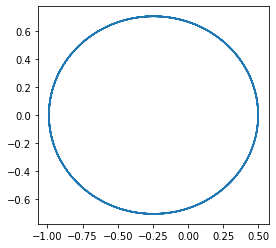

In [79]:
rx, ry = r[:,0],r[:,1]
ax = plt.subplot(1,1,1)
ax.set_aspect(1)
ax.plot(rx, ry)


<span style="color:blue"> Write down the system of ODEs that you want to solve with RK4, and define the corresponding `a_gravity_RK4` function.
</span>

In [4]:
# code copied from Lecture 12/13
# you don't need to change anything in this cell
def RK4_step(t, y, h, g, *P):
    """
    Implements a single step of a fourth-order, explicit Runge-Kutta scheme
    """
    thalf = t + 0.5*h
    k1 = h * g(t, y, *P)
    k2 = h * g(thalf, y + 0.5*k1, *P)
    k3 = h * g(thalf, y + 0.5*k2, *P)
    k4 = h * g(t + h, y + k3, *P)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

<span style="color:blue"> Next, we will consider the conservation of energy of the velocity Verlet algorithm and RK4.
Plot the total energy for both solvers as a function of time, for varying step sizes.</span>